<a href="https://colab.research.google.com/github/neocodered/EN3160_Image_Processing_and_Machine_Vision/blob/main/week7/h_camera_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imaging a Point Cloud Using a Camera Consructed by Specifying Extrinsic and Intrinsic Parameters

In [2]:
! pip install plyfile

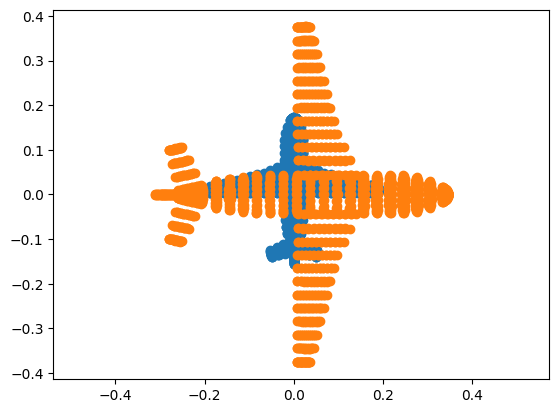

In [14]:
# https://people.sc.fsu.edu/~jburkardt/data/ply/ply.html
import numpy as np
from plyfile import PlyData, PlyElement
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

pcd =  PlyData.read(r"/content/airplane.ply") # Read the point cloud
points = np.concatenate((pcd['vertex']['x'].reshape(1,-1), pcd['vertex']['y'].reshape(1,-1), pcd['vertex']['z'].reshape(1,-1)), axis=0)
points = points - np.mean(points, axis = 1).reshape(3,1)

ones = np.ones((1, points.shape[1]))
points = np.concatenate((points, ones), axis=0)


P = np.array([[1., 0., 0., 0.],
              [0., 1., 0., 0.],
              [0., 0., 1., 0.]])

# Rotation matrix R is an orthonormal marix
R = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [0., 0., 1.]])
K = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [0., 0., 1.]])
t = np.array([[0.],
              [0.],
              [-4000.]])
P1 = np.matmul(K, np.concatenate((R, t), axis=1))# P = K[R|t] = K[R|-RC]

R = np.array([[0., 1., 0.],
              [1., 0., 0.],
              [0., 0., 1.]])
K = np.array([[2., 0., 0.],
              [0., 2., 0.],
              [0., 0., 1.]])
P2 = np.matmul(K, np.concatenate((R, t), axis=1))

fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
transfromed = P1 @ points
transfromed = transfromed/transfromed[2,:]
ax.scatter(transfromed[0,:], transfromed[1,:])

transfromed = P2 @ points
transfromed = transfromed/transfromed[2,:]
ax.scatter(transfromed[0,:], transfromed[1,:])
ax.axis('equal')
plt.show()


Text(0.5, 0, 'z')

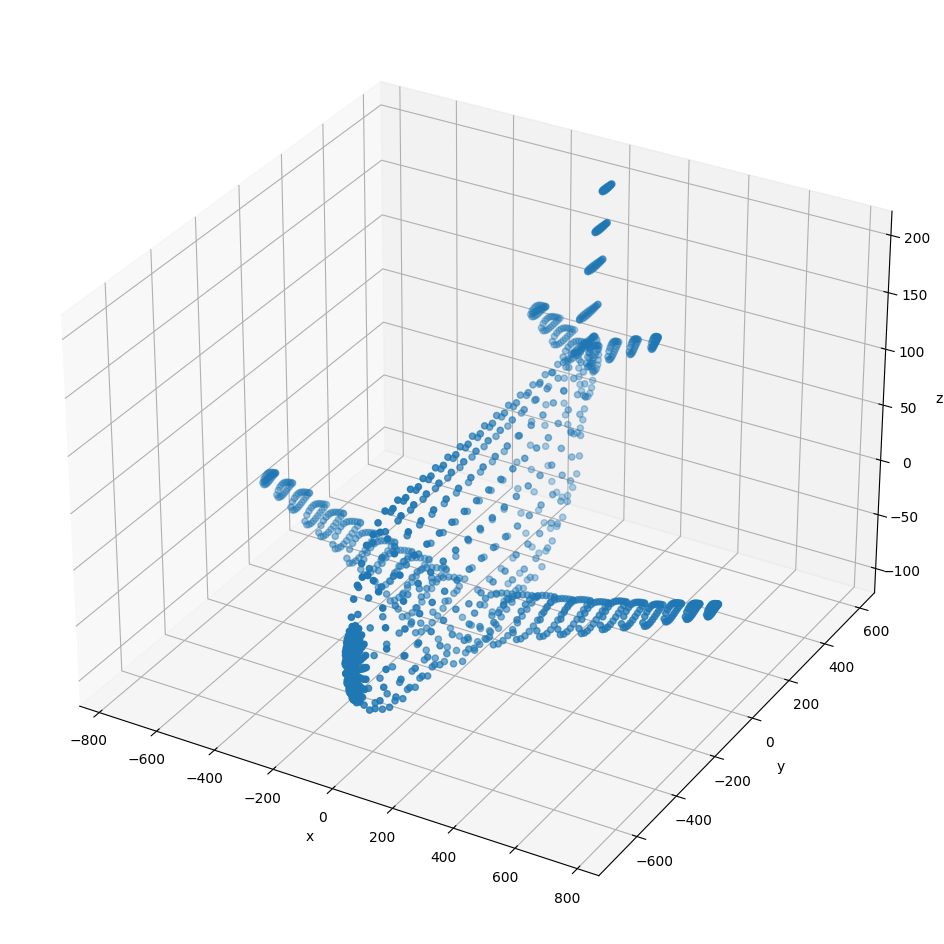

In [4]:
# Plot 3-D scatter
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(points[0,:], points[1,:], points[2,:])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [5]:
np.set_printoptions(precision=4, suppress=True)
print('P1\n', P1)
print('P2\n', P2)

P1
 [[    1.     0.     0.     0.]
 [    0.     1.     0.     0.]
 [    0.     0.     1. -4000.]]
P2
 [[    0.     2.     0.     0.]
 [    2.     0.     0.     0.]
 [    0.     0.     1. -4000.]]


# Recovering K,R and C

In [6]:
# RQ Decomposition
# http://ksimek.github.io/2012/08/14/decompose/
def rq(M):
    Q, R = np.linalg.qr(np.flipud(M).T)
#     print(Q)
#     print(R)
    R = np.flipud(R.T)
    R = np.fliplr(R)

    Q = Q.T;
    Q = np.flipud(Q)
    return R, Q

In [7]:
import numpy as np
# P = [M|-MC]
# P = K[R|-RC]
M = P2[:, 0:3]
C = np.linalg.inv(M)@P1[:,3] # camera center in world coordinates
K, R = rq(M)
K, R = rq(M)

# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)));

K = K @ T
R = T @ R # (T is its own inverse)
print(K)
print(R)

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [8]:
# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)));

K = K @ T;
R = T @ R; # (T is its own inverse)
print(K)
print(R)

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [9]:
# P from Hartley and Zisserman Example 6.2

Phz = np.array(
    [[3.53553e+2, 3.39645e+2, 2.77744e+2, -1.44946e+6],
     [-1.03528e+2, 2.33212e+1, 4.59607e+2, -6.32525e+5],
     [7.07107e-1, -3.53553e-1, 6.12372e-1, -9.18559e+2]])

In [10]:
# P = [M|-MC]
# P = K[R|-RC]
M = Phz[:, 0:3]
C = -np.linalg.inv(M)@Phz[:,3] # camera center in world coordinates
K, R = rq(M)
# K, R = scipy.linalg.rq(M)

# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)));

K = K @ T
R = T @ R # (T is its own inverse)
print(C)
print(K)
print(R)

# Checking again
P = K @ R @ np.concatenate((np.eye(3), -C.reshape(3,1)), axis=1)
print(P)

[1000.0007 2000.002  1500.0003]
[[468.1647  91.2251 300.    ]
 [  0.     427.2009 199.9999]
 [  0.       0.       1.    ]]
[[ 0.4138  0.9091  0.0471]
 [-0.5734  0.2201  0.7892]
 [ 0.7071 -0.3536  0.6124]]
[[     353.553       339.645       277.744  -1449460.    ]
 [    -103.528        23.3212      459.607   -632525.    ]
 [       0.7071       -0.3536        0.6124     -918.559 ]]


In [11]:
print(np.round(K, 2))

[[468.16  91.23 300.  ]
 [  0.   427.2  200.  ]
 [  0.     0.     1.  ]]


In [12]:
np.concatenate((np.eye(3), -C.reshape(3,1)), axis=1)

array([[    1.    ,     0.    ,     0.    , -1000.0007],
       [    0.    ,     1.    ,     0.    , -2000.002 ],
       [    0.    ,     0.    ,     1.    , -1500.0003]])

# Measurements

Assume that a camera is mounted with the optical axis perpendicular to the imaging plane (where the flat object is kept). A couple of objects is kept of this plane. If the focal length of the camera is
8
m
m
, the pixel size is
2.2
μ
m
×
2.2
μ
m
, and the distance from the lens to the imaging plane is
720
m
m
, what are the sizes of the Allen keys?

In [ ]:
# Printint are of each item in pixels

import cv2 as cv
import numpy as np
file_name = r'/content/earrings.jpg'
# file_name = r'images/sapphire.jpg'
im = cv.imread(file_name, cv.IMREAD_REDUCED_COLOR_2)
hsv = cv.cvtColor(im, cv.COLOR_BGR2HSV)
th, bw = cv.threshold(hsv[:, :, 1], 0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Closing to reove dots in object fg
w = 5
kernel = np.ones((w,w),np.uint8)
opened = cv.morphologyEx(bw, cv.MORPH_CLOSE, kernel)


# Commected components analysis with statistics
retval, labels, stats, centroids = cv.connectedComponentsWithStats(bw)
print(retval)
colomapped = cv.applyColorMap((labels/np.amax(labels)*255).astype('uint8'), cv.COLORMAP_PARULA)

Z = 720 #mm
f = 8 #mm
for i, s in enumerate(stats):
    if i != 0:
        print('Item ', i, ', area in pixels = ', s[4])
        print('Area in mm^2: ', s[4]*(2.2e-3)**2*(Z*Z)/(f*f))


cv.namedWindow('Images')
cv.imshow('Images', im)
cv.waitKey(0)
cv.imshow('Images', hsv[:, :, 1])
cv.waitKey(0)
cv.imshow('Images', bw)
cv.waitKey(0)
cv.imshow('Images', opened)
cv.waitKey(0)
cv.imshow('Images', colomapped)
cv.waitKey(0)
cv.destroyAllWindows()

3
Item  1 , area in pixels =  14799
Area in mm^2:  580.1799960000001
Item  2 , area in pixels =  14776
Area in mm^2:  579.2783039999999


# Measuring the Width of Allen Keys

Assume that a camera is mounted with the optical axis perpendicular to the imaging plane (where the flat object is kept). A set of Allen keys is kept of this plane. If the focal length of the camera is
5
m
m
, the pixel size is
4.8
μ
m
×
4.8
μ
m
, and the distance from the lens to the imaging plane is
30
m
m
, what are the sizes of the Allen keys?

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
file_name = r'/content/allenkeys.jpg'
im = cv.imread(file_name, cv.IMREAD_REDUCED_GRAYSCALE_2)
canny = cv.Canny(im, 50, 150)

# Copy edges to the images that will display the results in BGR
canny_color = cv.cvtColor(canny, cv.COLOR_GRAY2BGR)

lines = cv.HoughLines(canny,    1, np.pi / 180, 170, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(canny_color, pt1, pt2, (0,0,255), 1, cv.LINE_AA)


cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
cv.imshow('Image', im)
cv.waitKey(0)
cv.imshow('Image', canny)
cv.waitKey(0)
cv.imshow('Image', canny_color)
r = cv.selectROI('Image', canny_color, showCrosshair = True, fromCenter = False )
cv.waitKey(0)
print(r)

x0, y0 = int(r[0] + r[2]/2), int(r[1] + r[3]/2)
m = b/a # Gradient
m = np.tan(np.median(lines[:, 0,1]))
c = y0 - m*x0   # Intercept

cv.line(canny_color, (0, int(c)), (im.shape[0], int(m*im.shape[0] + c)), (0,255,0), 2, cv.LINE_AA)

cv.imshow('Image', canny_color)
cv.waitKey(0)
cv.destroyAllWindows()


dy = 1
y_sub_pixel = np.arange(0, im.shape[0] - 1, dy)
f_sub_pixel = np.zeros_like(y_sub_pixel)
f_sub_pixel_nn = np.zeros_like(y_sub_pixel)
# https://youtu.be/v9CFu4r6tPY

for i, y in enumerate(y_sub_pixel):
    x_l, x_h  = int(np.floor(y)), int(np.floor(y) + 1)
    y_l, y_h = int(m*y + c), int(m*y + c) + 1
    # a, b, c, d = im[y_l, x_l], im[y_h, x_l] , im[y_l, x_h], im[y_h, x_h]
    # y_l, y_h  = int(y), int(y) + 1
    # x_l, x_h = int(m*y + c), int(m*y + c) + 1
    # dx = m*y + c - x_l
    # dy = y - y_l
    # print(dx, dy)
    # f_sub_pixel[i] = (1 - dy)*im[x_l, y_l] + dy*im[x_h, y_l] + dx*((1-dy)*im[x_l, y_h] + dy*im[x_h, y_h] )

    f_sub_pixel_nn[i] = im[y_l, x_l]

fig, ax = plt.subplots(figsize=(30,5))
# ax.plot(f_sub_pixel)
ax.plot(f_sub_pixel_nn)

In [1]:
# Coded on Feb. 7, 2022
thresholded = f_sub_pixel_nn < 150
diff = np.diff(thresholded)
fig, ax = plt.subplots(2, figsize=(30,5))
ax[0].plot(thresholded)
ax[1].plot(diff)

transitions = np.squeeze(np.where(diff == 1))
widths = transitions[1::2] - transitions[:-1:2]
print('Widhts of Allen keys in pixels ', widths)
print('Widhts of Allen keys in mm ', widths*4.8e-3*350/5)

NameError: name 'f_sub_pixel_nn' is not defined

In [ ]:
print(5*10/(4.8e-3*29))
print((4.8e-3*29)*360/5)

In [ ]:
# https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/autonomous-vision/lectures/computer-vision/